In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ns_sr0yf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ns_sr0yf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=f0338444637d95993a3cfcd3ff7733def2d85920f32ba5b8de1e2a9b081cdca0
  Stored in directory: /tmp/pip-ephem-wheel-cache-k3cscwck/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-08-05 13:13:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.67.181.91, 18.67.181.104, 18.67.181.36, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.67.181.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   109MB/s    in 22s     

2024-08-05 13:13:22 (112 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
import torch
import torchvision

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint="sam_vit_h_4b8939.pth").to(device=DEVICE)

https://www.preci.co.jp/20181106/

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

import cv2
image_bgr = cv2.imread("/content/sem.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

In [6]:
!pip install -q jupyter_bbox_widget dataclasses-json supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.3 MB/s eta 0:00:00


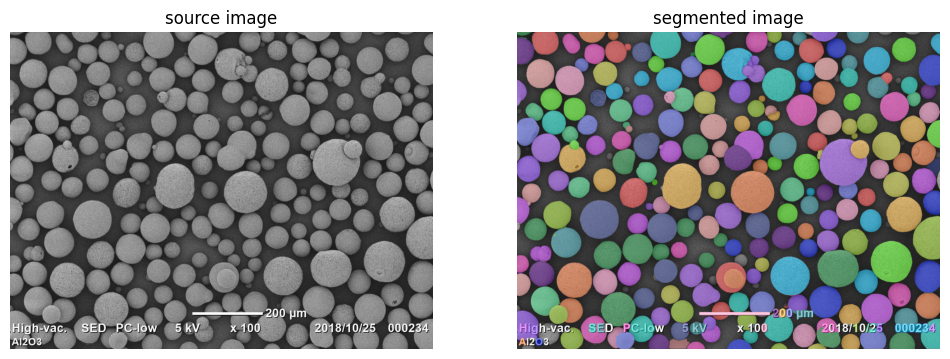

In [12]:
import supervision as sv

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)